<a href="https://colab.research.google.com/github/Bibhash123/competition_quickstart_dataloader/blob/main/gbm-models-lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install -U layer
clear_output(wait = False)

In [2]:
import layer
from layer.decorators import dataset,model, pip_requirements, resources
layer.login()

Please open the following link in your web browser. Once logged in, copy the code and paste it here.
https://app.layer.ai/oauth/authorize?response_type=code&code_challenge=X9nIhYVB5zjVjlQz_7TparZwmuuygFkKqT4q4HjH5T4&code_challenge_method=S256&client_id=0STDdcnpK48P8A429EAAn93WNuLmViLR&redirect_uri=https://app.layer.ai/oauth/code&scope=offline_access&audience=https://app.layer.ai
Code: pfzTQW9vr2eO3PkCSa05kjLGyymsYcb2BAtWqkiVtcEmA
Successfully logged into https://app.layer.ai


In [3]:
layer.init("rci-competition")

Your Layer project is here: https://app.layer.ai/bibhash/rci-competition

## Imports

In [1]:
import os
import gc
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
import warnings
from lightgbm import LGBMRegressor

warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
def rank_data(series):
    return (series.rank() - 1) / (len(series) - 1)

# **Data Preparation**

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
!wget https://rocketcompetition.mypinata.cloud/ipfs/QmbVhN84RZYuZ33JMrua8ngtnKcgVsbgM89rU6MTnhDuQa
!unzip -q QmbVhN84RZYuZ33JMrua8ngtnKcgVsbgM89rU6MTnhDuQa -d "/content/"
!rm -r QmbVhN84RZYuZ33JMrua8ngtnKcgVsbgM89rU6MTnhDuQa

--2022-08-15 16:06:56--  https://rocketcompetition.mypinata.cloud/ipfs/QmbVhN84RZYuZ33JMrua8ngtnKcgVsbgM89rU6MTnhDuQa
Resolving rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)... 104.18.31.237, 104.18.30.237, 2606:4700::6812:1fed, ...
Connecting to rocketcompetition.mypinata.cloud (rocketcompetition.mypinata.cloud)|104.18.31.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381604047 (364M) [application/zip]
Saving to: ‘QmbVhN84RZYuZ33JMrua8ngtnKcgVsbgM89rU6MTnhDuQa’

QmbVhN84RZYuZ33JMru 100%[===================>] 363.93M  10.9MB/s    in 32s     

2022-08-15 16:07:31 (11.3 MB/s) - ‘QmbVhN84RZYuZ33JMrua8ngtnKcgVsbgM89rU6MTnhDuQa’ saved [381604047/381604047]



### Loading train_dataset and validation_dataset

In [7]:
train_dataset  = pd.read_csv('/content/dataset/train_dataset.csv', index_col = 'date')
validation_dataset  = pd.read_csv('/content/dataset/validation_dataset.csv', index_col = 'date')
print("Shape of train set:",train_dataset.shape)
print("Shape of test set:",validation_dataset.shape)

Shape of train set: (86085, 2013)
Shape of test set: (716, 2013)


In [8]:
train_dataset = train_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)
validation_dataset = validation_dataset.sort_values(by=["symbol","date"]).reset_index(drop=False)

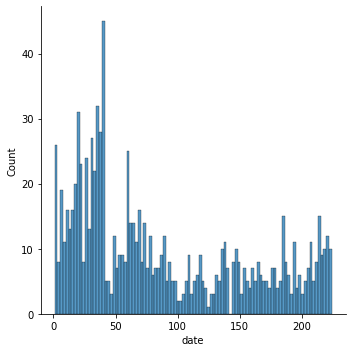

In [9]:
df = train_dataset.groupby("symbol")['date'].count().to_frame().reset_index()
sns.displot(df['date'],bins = 100)

In [10]:
# first column (symbol) is the ticker
# 'target_DC1' is the log of return for delta between current close to previous close
# 'target' is the y which is ranked by Era using 'target_DC1'
# the rest of the columns are features to be used for ML
train_dataset.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_2003,feature_2004,feature_2005,feature_2006,feature_2007,feature_2008,feature_2009,feature_DC1,target,target_DC1
0,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,0.887446,0.857143,0.857143,0.857143,0.835498,0.839827,0.839827,0.891775,0.095238,-0.211551
1,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,0.936709,0.953586,0.962025,0.932489,0.940928,0.945148,0.915612,0.101266,0.046414,-0.192849
2,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,0.891213,0.874477,0.857741,0.912134,0.849372,0.807531,0.878661,0.050209,0.284519,-0.263822
3,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,0.645833,0.600000,0.541667,0.691667,0.591667,0.504167,0.670833,0.287500,0.391667,0.023985
4,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,0.504098,0.454918,0.422131,0.553279,0.368852,0.331967,0.450820,0.397541,0.032787,-0.251842


In [11]:
info = train_dataset.describe().transpose().reset_index()

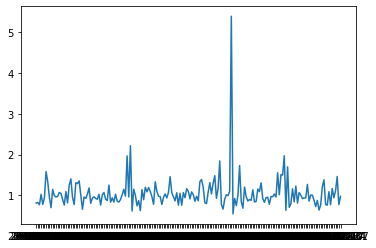

In [12]:
plt.plot(train_dataset[train_dataset['symbol']=='0xBTC']['date'], np.exp(train_dataset[train_dataset['symbol']=='0xBTC']['target_DC1']))

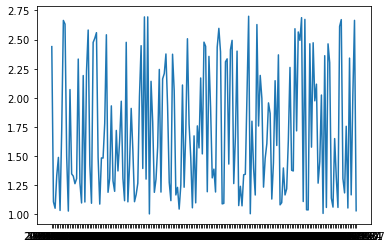

In [13]:
plt.plot(train_dataset[train_dataset['symbol']=='0xBTC']['date'], np.exp(train_dataset[train_dataset['symbol']=='0xBTC']['feature_DC1']))

In [16]:
symbols = train_dataset.symbol.unique()
trainsize = train_dataset.shape[0]

train_dataset = pd.concat([train_dataset, validation_dataset], axis = 0)
train_dataset['dc1_lag1'] = -1
train_dataset['dc1_lag1_rolling'] = -1
train_dataset['dc1_lag2'] = -1
train_dataset['target_lag1'] = -1
train_dataset['target_lag2'] = -1

for sym in tqdm(symbols):
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(1)
  train_dataset.loc[train_dataset['symbol']==sym,'target_lag1'] = train_dataset[train_dataset['symbol']==sym]['target'].shift(1)
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag2'] = train_dataset[train_dataset['symbol']==sym]['target_DC1'].shift(2)
  train_dataset.loc[train_dataset['symbol']==sym,'target_lag2'] = train_dataset[train_dataset['symbol']==sym]['target'].shift(2)
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1_rolling'] = train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'].rolling(window=3).sum()
  train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1_diff'] = train_dataset.loc[train_dataset['symbol']==sym,'dc1_lag1'].diff()
  
train_dataset['dc1_lag1_exp'] = np.exp(train_dataset['dc1_lag1'])
train_dataset.fillna(-1,inplace = True)
train_dataset['month'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.month)
train_dataset['year'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.year)
train_dataset['day'] = pd.to_datetime(train_dataset['date']).apply(lambda x: x.day)



validation_dataset = train_dataset.iloc[trainsize:]
train_dataset = train_dataset.iloc[:trainsize]

  0%|          | 0/980 [00:00<?, ?it/s]

### Create X and y from train_dataset

### Each era representing a set of cryptocurrency assets for the time period, the number of assets within each Era is different

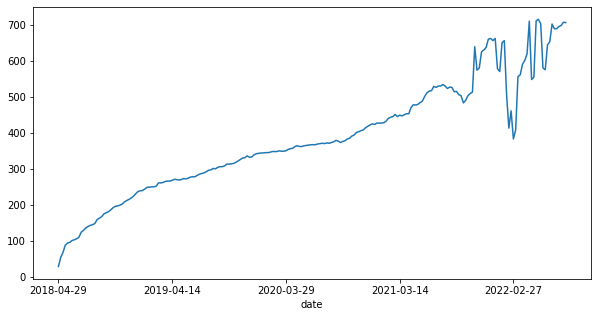

In [17]:
train_dataset.groupby(train_dataset.date).count().iloc[:,1].plot(figsize = (10,5));

### Split dataset into train and test by era

In [18]:
# Run Once
train = 0.9
test = 0.1
dates = sorted(train_dataset.date.unique())
era = len(dates)
train_era = int(era * train)
test_era = era - train_era
print('total Era: {}'.format(era))
print('train Era: {}'.format(train_era))
print('validation Era: {}'.format(test_era))

total Era: 224
train Era: 201
validation Era: 23


In [19]:
#split train and test set according to the train_era and test_era
# Run Once
train_set = train_dataset.loc[train_dataset.date < dates[train_era]]
val_set = train_dataset.loc[train_dataset.date >= dates[train_era]]
print('Train dataset shape: {}'.format(train_set.shape))
print('Validation dataset shape: {}'.format(val_set.shape))

Train dataset shape: (71448, 2024)
Validation dataset shape: (14637, 2024)


In [20]:
train_set.to_csv("train_set.csv",index = False)
val_set.to_csv("val_set.csv",index = False)
validation_dataset.to_csv("test_set.csv",index = False)

In [ ]:
os.kill(os.getpid(), 9)

In [5]:
train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")
validation_dataset= pd.read_csv("test_set.csv")

In [6]:
train_set.head()

,date,symbol,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,dc1_lag1,dc1_lag1_rolling,dc1_lag2,target_lag1,target_lag2,dc1_lag1_diff,dc1_lag1_exp,month,year,day
0,2018-12-23,0xBTC,0.974026,0.987013,0.978355,0.991342,0.982684,0.982684,0.982684,0.978355,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,12,2018,23
1,2018-12-30,0xBTC,0.016878,0.033755,0.949367,0.936709,0.978903,0.907173,0.962025,0.953586,...,-0.211551,-1.000000,-1.000000,0.095238,-1.000000,-1.000000,0.809328,12,2018,30
2,2019-01-06,0xBTC,0.158996,0.016736,0.033473,0.928870,0.868201,0.941423,0.740586,0.933054,...,-0.192849,-1.000000,-0.211551,0.046414,0.095238,0.018702,0.824607,1,2019,6
3,2019-01-13,0xBTC,0.737500,0.279167,0.020833,0.054167,0.945833,0.908333,0.962500,0.870833,...,-0.263822,-0.668222,-0.192849,0.284519,0.046414,-0.070974,0.768110,1,2019,13
4,2019-01-20,0xBTC,0.983607,0.987705,0.983607,0.430328,0.971311,0.991803,0.987705,0.991803,...,0.023985,-0.432686,-0.263822,0.391667,0.284519,0.287807,1.024275,1,2019,20


In [7]:
with_target = True

In [8]:
from xgboost import XGBRegressor

params = {'objective' : "reg:squarederror", 
          'n_estimators' : 1000, 
          'tree_method' : "gpu_hist", 
          'learning_rate': 0.03,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
          'reg_alpha':0.1,
          'reg_lambda':0.01,
          'subsample': 0.8,
          'colsample_bytree':0.8,
          'colsample_bylevel':0.8,
          'max_depth':9, 
          "reg_alpha":0.01
}

def fitXGB(with_target = with_target):
  X_train = train_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  X_val = val_set.drop(['date','symbol','target','target_DC1'], axis = 1)

  if with_target:
    Y_train = train_set['target']
    Y_val = val_set['target']
  else:
    Y_train = train_set['target_DC1']
    Y_val = val_set['target_DC1']
  
  reg = XGBRegressor(**params)
  reg.fit(X_train,Y_train, eval_metric = "rmse",
          eval_set=[(X_train,Y_train),(X_val,Y_val)], 
          early_stopping_rounds = 10)
  return reg

xgb = fitXGB()

[0]	validation_0-rmse:0.28855	validation_1-rmse:0.288959
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.287674	validation_1-rmse:0.288818
[2]	validation_0-rmse:0.286804	validation_1-rmse:0.288661
[3]	validation_0-rmse:0.285934	validation_1-rmse:0.28856
[4]	validation_0-rmse:0.285003	validation_1-rmse:0.288449
[5]	validation_0-rmse:0.284169	validation_1-rmse:0.288346
[6]	validation_0-rmse:0.283325	validation_1-rmse:0.2882
[7]	validation_0-rmse:0.282523	validation_1-rmse:0.288067
[8]	validation_0-rmse:0.281708	validation_1-rmse:0.287935
[9]	validation_0-rmse:0.280897	validation_1-rmse:0.28785
[10]	validation_0-rmse:0.28018	validation_1-rmse:0.287785
[11]	validation_0-rmse:0.279466	validation_1-rmse:0.287754
[12]	validation_0-rmse:0.278702	validation_1-rmse:0.287656
[13]	validation_0-rmse:0.277961	validation_1-rmse:0.287629
[14]	validation_0-rmse:0.277232

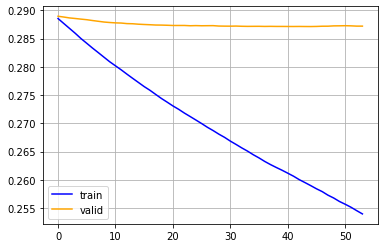

In [9]:
evals = xgb.evals_result()
evaluation_plot = plt.figure()
plt.grid()
plt.plot(evals['validation_0']['rmse'],c='blue',label = 'train')
plt.plot(evals['validation_1']['rmse'],c='orange',label = 'valid')
plt.legend()

In [10]:
import lightgbm as lgb

params = {'boosting_type': 'gbdt',
          'n_estimators':1000,
          'objective': 'regression',
          'learning_rate': 0.03,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
          'reg_alpha':0.1,
          'reg_lambda':0.01,
          'max_depth':9,
          'subsample': 0.8,
          'colsample_bytree':0.8,
          'colsample_bylevel':0.8
          }
evals = {}

def fitLGB(with_target = with_target):
  X_train = train_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  X_val = val_set.drop(['date','symbol','target','target_DC1'], axis = 1)
  cats = ['month','year','day']
  feature_name = X_train.columns.to_list()

  if with_target:
    Y_train = train_set['target']
    Y_val = val_set['target']
  else:
    Y_train = train_set['target_DC1']
    Y_val = val_set['target_DC1']
  
  reg = LGBMRegressor(**params)
  reg.fit(X_train,Y_train,
          eval_metric = "rmse",
          feature_name = feature_name ,
          categorical_feature = cats,
          early_stopping_rounds = 10,
          callbacks = [lgb.record_evaluation(evals)],
          eval_set=[(X_train,Y_train), (X_val,Y_val)],
          eval_names=['train','valid'])
  return reg

lgb = fitLGB()

[1]	train's l2: 0.0836415	train's rmse: 0.289208	valid's l2: 0.0835227	valid's rmse: 0.289003
Training until validation scores don't improve for 10 rounds.
[2]	train's l2: 0.0834807	train's rmse: 0.28893	valid's l2: 0.0834627	valid's rmse: 0.288899
[3]	train's l2: 0.0833244	train's rmse: 0.28866	valid's l2: 0.0833982	valid's rmse: 0.288787
[4]	train's l2: 0.0831731	train's rmse: 0.288397	valid's l2: 0.0833391	valid's rmse: 0.288685
[5]	train's l2: 0.0830339	train's rmse: 0.288156	valid's l2: 0.0832821	valid's rmse: 0.288586
[6]	train's l2: 0.0828926	train's rmse: 0.287911	valid's l2: 0.0832345	valid's rmse: 0.288504
[7]	train's l2: 0.0827644	train's rmse: 0.287688	valid's l2: 0.0831834	valid's rmse: 0.288415
[8]	train's l2: 0.0826335	train's rmse: 0.28746	valid's l2: 0.0831518	valid's rmse: 0.28836
[9]	train's l2: 0.0825075	train's rmse: 0.287241	valid's l2: 0.0831294	valid's rmse: 0.288322
[10]	train's l2: 0.0823873	train's rmse: 0.287032	valid's l2: 0.0831061	valid's rmse: 0.288281
[

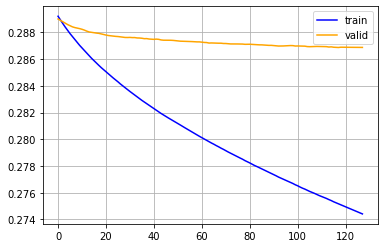

In [11]:
evaluation_plot = plt.figure()
plt.grid()
plt.plot(evals['train']['rmse'],c='blue',label = 'train')
plt.plot(evals['valid']['rmse'],c='orange',label = 'valid')
plt.legend()

In [12]:
def predictFunction(xgb, lgb, dataset, with_target = with_target):
  files = dataset.copy()
  xgb_pred = xgb.predict(files.drop(['date','symbol','target','target_DC1'], axis = 1))
  lgb_pred = lgb.predict(files.drop(['date','symbol','target','target_DC1'], axis = 1))

  if with_target:
    files.loc[:,'predicted_target'] = (xgb_pred.reshape((-1,1))+lgb_pred.reshape((-1,1)))/2
  else:
    files.loc[:,'predicted_DC1'] = (xgb_pred.reshape((-1,1))+lgb_pred.reshape((-1,1)))/2
    files.loc[:,'predicted_target'] = -1
    for date in files.date.unique():
      files.loc[files['date']==date,'predicted_target'] = rank_data(files[files['date']==date]['predicted_DC1'])
      
  return files[['symbol','date','predicted_target']]

In [13]:
# function to calculate Spearman correlation by era (mean, std, max, min)
# we want to maximize but maintain stable correlation across era to maximize both challenge and competition reward
def spearman_by_era(prediction,target, dates):
  df = pd.DataFrame(index=dates,
                    data = {'prediction': prediction,
                            'target': target}
                    )
  spearman_era_list = []
  for era in df.index.unique():
    era_df = df[df.index == era]
    spearman_corr = sp.stats.spearmanr(era_df.prediction, era_df.target)[0]
    spearman_era_list.append(spearman_corr)

  mean = np.mean(spearman_era_list)
  std = np.std(spearman_era_list)
  max = np.max(spearman_era_list)
  min = np.min(spearman_era_list)
  return mean, std, max, min
  

In [14]:
pred_train = predictFunction(xgb,lgb, train_set)
train_spearman = spearman_by_era(pred_train['predicted_target'].values, train_set['target'].values,
                                pred_train['date'].values)

print('Train dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(train_spearman[0], 4), 
                                                                                            round(train_spearman[1], 4),
                                                                                            round(train_spearman[2], 4),
                                                                                            round(train_spearman[3], 4),
                                                                                            ))


Train dataset Spearman correlation: mean = 0.547 ; std = 0.0589 ; max = 0.7032 ; min = 0.3615


In [15]:
pred_val = predictFunction(xgb, lgb, val_set)
test_spearman = spearman_by_era(pred_val['predicted_target'].values, val_set['target'].values,
                                pred_val['date'].values)

print('Test dataset Spearman correlation: mean = {} ; std = {} ; max = {} ; min = {}'.format(round(test_spearman[0], 4),
                                                                                            round(test_spearman[1], 4),
                                                                                            round(test_spearman[2], 4),
                                                                                            round(test_spearman[3], 4),
                                                                                            ))

Test dataset Spearman correlation: mean = 0.1051 ; std = 0.0729 ; max = 0.2682 ; min = -0.0248


In [16]:
mse = mean_squared_error(pred_val['predicted_target'],val_set['target'])
mae = mean_absolute_error(pred_val['predicted_target'],val_set['target'])
rmse = mean_squared_error(pred_val['predicted_target'],val_set['target'], squared = False)

In [17]:
error = train_set[['symbol','date','target','target_DC1']].copy()
error['predicted'] = predictFunction(xgb, lgb, train_set)['predicted_target']
error['error'] = (error['target']-error['predicted'])**2
error

,symbol,date,target,target_DC1,predicted,error
0,0xBTC,2018-12-23,0.095238,-0.211551,0.447161,0.123850
1,0xBTC,2018-12-30,0.046414,-0.192849,0.468297,0.177985
2,0xBTC,2019-01-06,0.284519,-0.263822,0.480294,0.038328
3,0xBTC,2019-01-13,0.391667,0.023985,0.495068,0.010692
4,0xBTC,2019-01-20,0.032787,-0.251842,0.508172,0.225991
...,...,...,...,...,...,...
71443,ZYN,2022-01-02,0.984894,0.447752,0.545407,0.193149
71444,ZYN,2022-01-23,0.884615,0.143837,0.476837,0.166284
71445,ZYN,2022-01-30,0.983232,0.591620,0.461330,0.272382
71446,ZYN,2022-02-06,0.045365,-0.254563,0.397253,0.123825


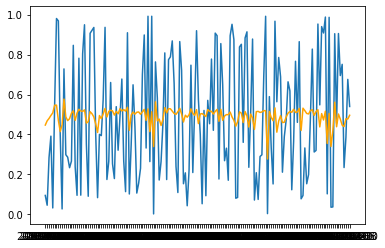

In [18]:
plt.plot(error[error['symbol']=='0xBTC'].date, error[error['symbol']=='0xBTC'].target)
plt.plot(error[error['symbol']=='0xBTC'].date, error[error['symbol']=='0xBTC'].predicted, color='orange')

In [19]:
error[error['error']==np.max(error['error'])]

,symbol,date,target,target_DC1,predicted,error
20669,DTH,2020-07-19,1.0,2.722598,0.386905,0.375885


In [20]:
error[error['error']==np.min(error['error'])]

,symbol,date,target,target_DC1,predicted,error
24440,FARM,2021-09-19,0.497018,-0.161689,0.497014,1.541059e-11


In [21]:
error[["target","target_DC1","error"]].corr()

,target,target_DC1,error
target,1.000000,0.672581,0.046733
target_DC1,0.672581,1.000000,0.121537
error,0.046733,0.121537,1.000000


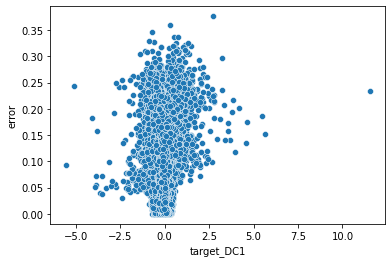

In [22]:
error_plot = plt.figure()
sns.scatterplot(x = "target_DC1", y = "error", data = error)

In [25]:
@model("lgb_model")
def train_function():  
    importance = lgb.feature_importances_
    importances_rfc_df = pd.DataFrame(importance, index=train_set.drop(['date','symbol','target','target_DC1'], axis = 1).columns, columns=['Importance'])
    importances_rfc_df = importances_rfc_df.sort_values(by='Importance', ascending=False)
    importances_rfc_df = importances_rfc_df[importances_rfc_df['Importance'] > 0]
    print("[INFO] Number of important features:",importances_rfc_df.shape[0])
    importances_rfc_df = importances_rfc_df.head(15)

    plt.figure(figsize=(8,8))
    plt.xticks(rotation=60, fontsize = 20)
    sns.barplot(y=importances_rfc_df.index, x=importances_rfc_df['Importance'])
    
    
    layer.log(params)
    layer.log({'With Target':with_target})
    layer.log({'Mean Absolute Error':mae})
    layer.log({'Mean Squarred Error': mse})
    layer.log({'Root Mean Squared Error': rmse})
    layer.log({"Train mean pearson":round(train_spearman[0], 4)})
    layer.log({"Train std pearson":round(train_spearman[1], 4)})
    layer.log({"Validation mean pearson":round(test_spearman[0], 4)})
    layer.log({"Validation std pearson":round(test_spearman[1], 4)})
    layer.log({"Feature importance": plt.gcf()})
    layer.log({"Training metrics": evaluation_plot})
    layer.log({"Error Plot":error_plot})
    plt.show()
    return lgb

_ = train_function()

Output()

[INFO] Number of important features: 1135


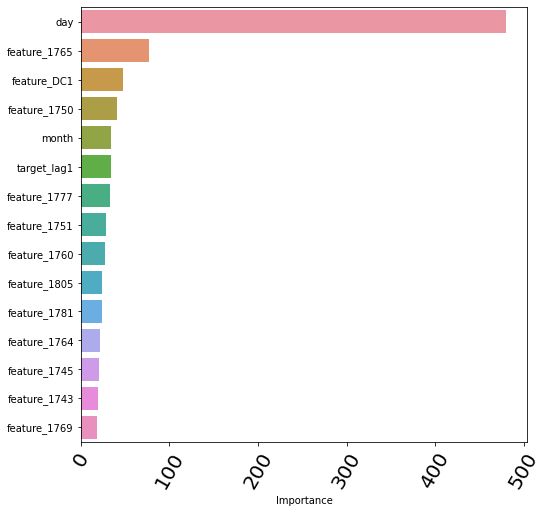

In [23]:
importance = lgb.feature_importances_
importances_rfc_df = pd.DataFrame(importance, index=train_set.drop(['date','symbol','target','target_DC1'], axis = 1).columns, columns=['Importance'])
importances_rfc_df = importances_rfc_df.sort_values(by='Importance', ascending=False)
importances_rfc_df = importances_rfc_df[importances_rfc_df['Importance'] > 0]
print("[INFO] Number of important features:",importances_rfc_df.shape[0])
importances_rfc_df = importances_rfc_df.head(15)

plt.figure(figsize=(8,8))
plt.xticks(rotation=60, fontsize = 20)
sns.barplot(y=importances_rfc_df.index, x=importances_rfc_df['Importance'])

In [24]:
pred_submission = predictFunction(xgb, lgb, validation_dataset)
pred_submission

,symbol,date,predicted_target
0,0xBTC,2022-08-14,0.524608
1,1ECO,2022-08-14,0.561365
2,1INCH,2022-08-14,0.523747
3,1WO,2022-08-14,0.488343
4,AAB,2022-08-14,0.511937
...,...,...,...
711,ZLW,2022-08-14,0.522280
712,ZORA,2022-08-14,0.321542
713,ZRX,2022-08-14,0.499559
714,ZSC,2022-08-14,0.491442


In [25]:
# Use the trained Linear Regression model to make prediction on latest data
# X_validation = validation_dataset.iloc[:, 1:-2]
# y_validation_linear_reg = reg.predict(X_validation)
y_validation_linear_reg = pred_submission['predicted_target'].values
y_validation_linear_reg[:5]

array([0.52460812, 0.56136463, 0.52374705, 0.48834342, 0.51193705])

### Let's use the prediction from linear regression to join with validation dataset symbol for submission

In [26]:
prediction = pd.DataFrame()
prediction['symbol'] = list(pred_submission.symbol)
prediction['prediction'] = y_validation_linear_reg

# sort the prediction to check which symbol is weaker and stronger, ie. FOX is weakest; BTC is strongest
prediction.sort_values('prediction')

,symbol,prediction
254,GEN,0.320166
712,ZORA,0.321542
317,JRT,0.337113
272,GSWAP,0.338123
32,ART,0.339697
...,...,...
404,MYB,0.597895
43,AWC,0.606630
79,BOR,0.641584
698,YFFII,0.649770


### Check is prediction dataframe in accordance for submission format (using the prediction from linear regression)

In [27]:
#check if y_latest is in accordance to shape for submission
if set(prediction.symbol) == set(validation_dataset.symbol):
    print('symbol matched!')
else:
    print('symbol unmatched, the symbol in prediction df must match the symbol in validation_dataset...')
    
if prediction.shape[1] == 2:
    print('column counts ok!')
else:
    print('It should have 2 columns, first column with symbol, second with prediction...')


symbol matched!
column counts ok!


### Output prediction as a .csv file for submission!

In [28]:
#Output submission as .csv file
#The prediction.csv is stored in content/prediction folder
import os
if not os.path.exists('/content/prediction'):
    os.makedirs('/content/prediction')
prediction.to_csv('/content/prediction/prediction.csv', index = False, header = None)

# **Submission Section**

## **Setup**

In [29]:
!git clone https://github.com/rocketcapital-ai/competition_submission.git
%cd /content/competition_submission

Cloning into 'competition_submission'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 3), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (23/23), done.
/content/competition_submission


In [30]:
!pip install base58
!pip install PyYAML
!pip install requests
!pip install web3==5.29.2
!pip install pandas 
from IPython.display import clear_output
clear_output(wait = False)

In [31]:
from lib.submitter import *

jwt = 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJ1c2VySW5mb3JtYXRpb24iOnsiaWQiOiIxMDIwZDY0OC1kNzQ5LTQ5YjItOTZmZS1hNWQ0NDY5ODRjNTQiLCJlbWFpbCI6ImJpYmhhc2hwLmRhc0BnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwicGluX3BvbGljeSI6eyJyZWdpb25zIjpbeyJpZCI6IkZSQTEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX0seyJpZCI6Ik5ZQzEiLCJkZXNpcmVkUmVwbGljYXRpb25Db3VudCI6MX1dLCJ2ZXJzaW9uIjoxfSwibWZhX2VuYWJsZWQiOmZhbHNlLCJzdGF0dXMiOiJBQ1RJVkUifSwiYXV0aGVudGljYXRpb25UeXBlIjoic2NvcGVkS2V5Iiwic2NvcGVkS2V5S2V5IjoiYmM4NWI0ZDQ1N2FhYWZlNzBmNGIiLCJzY29wZWRLZXlTZWNyZXQiOiJlMmEyOGFlZmFlNTcyMWZkNzM1Mjg4NzE5OTIzYTBkZTQ4MWY5NzUxZWQyZmVhMTE0MGJmYzRlNzNjNzRhYzI2IiwiaWF0IjoxNjU1MTM2Nzc4fQ.xl2FxgrL04kQIa7cIn89a_iE0I9xphiNf6K5K2mor5o'      # User-specified field.
address = '0xcF16365d53ed53055f39010830e3CcD5A7a8245E'  # User-specified field.
pk = '32316dfe607ed4a240ac29a6dcad9db6f484f0fbdf7894c15511237e1e13db70'       # User-specified field.
submitter = Submitter(jwt, address, pk)

## View wallet address information.

In [32]:
print('MATIC balance for {}: {}'.format(submitter.address, submitter.get_matic_balance()))
print('MUSA balance for {}: {}'.format(submitter.address, submitter.get_musa_balance()))
print('Current stake for {}: {}'.format(submitter.address, submitter.get_stake()))

MATIC balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 0.980523475163870781
MUSA balance for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 0.869313545300001154
Current stake for 0xcF16365d53ed53055f39010830e3CcD5A7a8245E: 264.943605785000001024


## **Retrieve Dataset and run models.**
### Please follow the instructions and example found [here](https://github.com/rocketcapital-ai/competition_quickstart_dataloader).

### When completed, please place final prediction csv file in the `file_to_submit` folder.

In [33]:
!cp "/content/prediction/prediction.csv" "/content/competition_submission/file_to_submit/"

## **Set stake.** (optional)
### Skip if no changes need to be made.

In [34]:
# set_stake_amount = 125.00  # User-specified field.
# transaction_success = submitter.set_stake(set_stake_amount)
# assert transaction_success, 'Setting stake failed.'

## **Submit predictions.**
Note that the same `submit_prediction` method should be used for re-submitting predictions.

In [35]:
submission_file_name = 'prediction.csv'  # User-specified field.
transaction_success = submitter.submit_prediction(submission_file_name)
assert transaction_success, 'Submission failed.'

Encrypting file.
Zipping encrypted file.
Uploading and recording on blockchain.
Setting gas price to 87 gwei.
Sending transaction 0x8d0281233191e3b422dae3e191a5287a7e941ac3315864aef9f46221b3779a9a
Transaction sent. Tx ID: 0x8d0281233191e3b422dae3e191a5287a7e941ac3315864aef9f46221b3779a9a


### **Retrieve and double-check predictions.** (optional)
This section retrieves your submitted files, decrypts them, and compares them to the original file in `file_to_submit`.

If the verification fails, please wait a few minutes and perform the verification again. If the problem persists, please re-submit your predictions.

In [36]:
verification_success = submitter.download_and_check(submission_file_name)
assert verification_success, 'Submission verification failed.'
print('Files are identical. Verification check passed.')

Retrieving file.
File retrieved.
File unzipped.
File decrypted. Comparing files.
Removing temp files.
Temp files removed.
Files are identical. Verification check passed.
